Grundlegender Aufbau:
Imports
Aufgabe 5

In [2]:
import Lab3Functions as lf3
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt, hilbert
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [3]:
weights, mvc, fatigue = lf3.import_data(';')

print(fatigue)
print(fatigue.iloc[2000])

        emg      t
0      1499   1618
1      1499   1620
2      1499   1623
3      1499   1626
4      1500   1628
...     ...    ...
20811  1462  53340
20812  1467  53343
20813  1473  53345
20814  1481  53348
20815  1492  53350

[20816 rows x 2 columns]
emg    1512
t      6546
Name: 2000, dtype: object


In [4]:
def remove_offset(emg):
    """Entfernt Mittel um Offset zu eliminieren"""
    return emg - np.mean(emg)

def bandpass_filter(emg, lowcut, highcut, fs, order=4):
    """
    Nutzt Butterworth Filter um nur Frequenzen zwischen lowcut und highcut zu behalten
    In unserem Fall zw. 20 und 450 Herz
    """
    nyquist = 0.5 * fs  # Nyquist-Frequenz = halbe Sampling-Frequenz
    low = lowcut / nyquist  # Normierte untere Grenzfrequenz
    high = highcut / nyquist  # Normierte obere Grenzfrequenz
    b, a = butter(order, [low, high], btype='band')  # Butterworth-Bandpassfilter
    return filtfilt(b, a, emg)  # Signal filtern (vorwärts und rückwärts für Null-Phasenverschiebung)

def rectify_signal(emg):
    """Wandelt alle negativen Werte in positive um"""
    return np.abs(emg)

def calculate_envelope(emg, fs, cutoff=3, order=2):
    """Durch Hilbert-Transformation - Hüllkurve des EMG-Signals, Tiefpass glättet, 3Hz aus Angabe"""
    nyquist = 0.5 * fs  # Nyquist-Frequenz
    low = cutoff / nyquist  # Normierte Grenzfrequenz des Lowpass-Filters
    b, a = butter(order, low, btype='low')  # Butterworth-Tiefpassfilter
    analytic_signal = hilbert(emg)  # Hilbert-Transformation, um die Hüllkurve zu extrahieren
    envelope = np.abs(analytic_signal)  # Betrag des analytischen Signals
    return filtfilt(b, a, envelope)  # Glätten der Hüllkurve

def process_emg(data, fs):
    """
    Funktion welche die EMG-Daten verarbeitet
    Input: data (DataFrame mit 't' und 'emg' Spalten), fs (Sampling-Frequenz)
    Output: DataFrame mit 't', 'emg_filtered', 'emg_rectified', 'emg_envelope' Spalten
    """
    # Schritt a: Offset eliminieren
    emg_no_offset = remove_offset(data['emg'])
    # Schritt b: Bandpass-Filterung (20-450 Hz)
    emg_filtered = bandpass_filter(emg_no_offset, 20, 190, fs)
    # Schritt c: Signal gleichrichten
    emg_rectified = rectify_signal(emg_filtered)
    # Schritt d: Hüllkurve bilden
    emg_envelope = calculate_envelope(emg_filtered, fs)
    
    # Zusammenfassen der Ergebnisse in einem neuen DataFrame
    result = pd.DataFrame({
        't': data['t'],  # Zeit bleibt unverändert
        'emg_no_offset': emg_no_offset,  # EMG ohne Offset
        'emg_filtered': emg_filtered,  # Gefiltertes EMG
        'emg_rectified': emg_rectified,  # Gleichgerichtetes Signal
        'emg_envelope': emg_envelope  # Hüllkurve
    })
    return result

# Basierend auf den vorliegenden Daten (Sampling-Periode von ~2.43 ms).
sampling_frequency = 411.76  # Hz

# Daten verarbeiten
mvc_processed = process_emg(mvc, sampling_frequency)

# Erstelle Subplots mit jeweils 2 Plots nebeneinander pro Zeile
fig = make_subplots(
    rows=4, cols=2,
    subplot_titles=[
        "Original EMG", "Mean-Corrected EMG",
        "Unfiltered EMG", "Filtered EMG",
        "Unrectified EMG", "Rectified EMG",
        "Rectified EMG", "Envelope"
    ]
)
def calculate_median_frequency(power, frequencies):
    area_freq = scipy.integrate.cumtrapz(power, frequencies, initial=0)
    total_power = area_freq[-1]
    median_freq = frequencies[np.where(area_freq >= total_power / 2)[0][0]]
    return median_freq

# Original vs. Mean-Corrected
fig.add_trace(go.Scatter(x=(mvc['t'] / 1000), y=mvc['emg'], mode='lines', name="Original EMG"), row=1, col=1)
fig.add_trace(go.Scatter(x=(mvc['t'] / 1000), y=mvc_processed['emg_no_offset'], mode='lines', name="Mean-Corrected EMG"), row=1, col=2)

# Unfiltered vs. Filtered
fig.add_trace(go.Scatter(x=(mvc['t'] / 1000), y=mvc_processed['emg_no_offset'], mode='lines', name="Unfiltered EMG"), row=2, col=1)
fig.add_trace(go.Scatter(x=(mvc['t'] / 1000), y=mvc_processed['emg_filtered'], mode='lines', name="Filtered EMG"), row=2, col=2)

# Unrectified vs. Rectified
fig.add_trace(go.Scatter(x=(mvc['t'] / 1000), y=mvc_processed['emg_filtered'], mode='lines', name="Unrectified EMG"), row=3, col=1)
fig.add_trace(go.Scatter(x=(mvc['t'] / 1000), y=mvc_processed['emg_rectified'], mode='lines', name="Rectified EMG"), row=3, col=2)

# Rectified vs. Envelope
fig.add_trace(go.Scatter(x=(mvc['t'] / 1000), y=mvc_processed['emg_rectified'], mode='lines', name="Rectified EMG"), row=4, col=1)
fig.add_trace(go.Scatter(x=(mvc['t'] / 1000), y=mvc_processed['emg_envelope'], mode='lines', name="Envelope"), row=4, col=2)

# Layout anpassen
fig.update_layout(
    title="Comparison of MVC Processing Steps",
    height=1200,  # Gesamthöhe des Plots
    width=1000,  # Gesamtbreite des Plots
    font=dict(size=14),  # Schriftgröße
    title_font=dict(size=18),  # Schriftgröße für den Titel
    showlegend=False,  # Legende nicht anzeigen
    template="plotly_white",
)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
# Y-Achsen individuell beschriften
fig.update_yaxes(title="Original EMG", row=1, col=1)
fig.update_yaxes(title="Mean-Corrected EMG", row=1, col=2)
fig.update_yaxes(title="Unfiltered EMG", row=2, col=1)
fig.update_yaxes(title="Filtered EMG", row=2, col=2)
fig.update_yaxes(title="Unrectified EMG", row=3, col=1)
fig.update_yaxes(title="Rectified EMG", row=3, col=2)
fig.update_yaxes(title="Rectified EMG", row=4, col=1)
fig.update_yaxes(title="Envelope", row=4, col=2)

# Plots anzeigen
fig.show()


In [5]:
# Daten verarbeiten
mvc_processed = process_emg(mvc, sampling_frequency)
weights_processed = process_emg(weights, sampling_frequency)
fatigue_processed = process_emg(fatigue, sampling_frequency)

#mvc_s,mvc_e,weights_s,weights_e,fatigues,fatiguee = lf3.get_bursts(mvc_processed['emg_filtered'],weights_processed['emg_filtered'],weights_processed['emg_filtered'])

Aufgabe 8

C:\Users\erics\AppData\Local\Temp\ipykernel_20708\2192407519.py:41: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.0000e+00 3.0000e-03 5.0000e-03 ... 2.1938e+01 2.1940e+01 2.1942e+01]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\erics\AppData\Local\Temp\ipykernel_20708\2192407519.py:42: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.0000e+00 2.0000e-03 4.0000e-03 ... 1.3303e+01 1.3305e+01 1.3307e+01]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\erics\AppData\Local\Temp\ipykernel_20708\2192407519.py:43: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.0000e+00 2.0000e-03 4.0000e-03 ... 1.1021e+01 1.1023e+01 1.1026e+01]' has dtype incompatible with int64, please ex

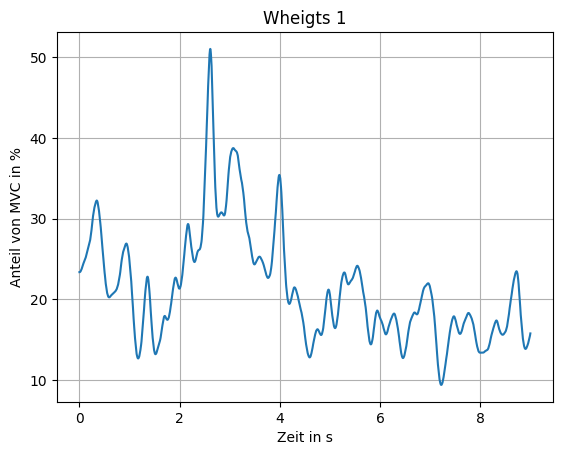

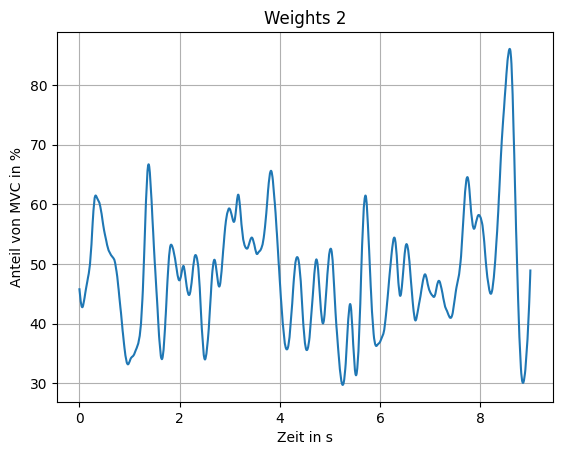

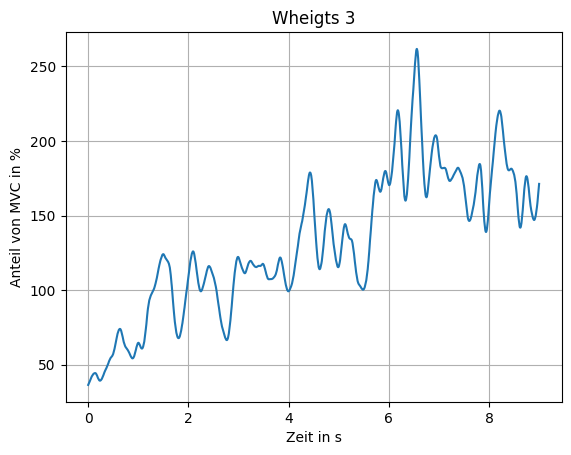

In [6]:
#MVC-Wert (Maximum Voluntary Contraction)
MVC = 18.157144482993942  # mV
sampling_frequency = 411.76  # Hz
mvc_processed = process_emg(mvc, sampling_frequency)
weights_processed = process_emg(weights, sampling_frequency)
fatigue_processed = process_emg(fatigue, sampling_frequency)

# Normalize the EMG envelope to MVC
weights_processed['emg_envelope_normalized'] = weights_processed['emg_envelope'] / MVC * 100

# Weights plotting
"""plt.figure()

plt.subplot(2, 1, 1)
plt.plot(weights_processed['t'], weights_processed['emg_envelope_normalized'], label='Filtered EMG (Normalized)')
plt.legend()
plt.title('Weights Experiment')
plt.xlabel('Time [s]')
plt.ylabel('EMG [% MVC]')
plt.grid()
plt.show()"""

# MVC-Wert (Maximum Voluntary Contraction)
MVC = 18.157144482993942  # mV
sampling_frequency = 411.76  # Hz

# Gewichtsdaten einlesen
weights1 = pd.read_csv('Weight1.txt', delimiter=';')  # 2.5 kg
weights2 = pd.read_csv('Weight2.txt', delimiter=';')  # 5 kg
weights3 = pd.read_csv('Weight3.txt', delimiter=';')  # 10 kg

# Indexlängen der Gewichtsdaten finden
weights1_length = len(weights1)
weights2_length = len(weights2)
weights3_length = len(weights3)
weights1_processed = weights_processed[:weights1_length]
weights2_processed = weights_processed[weights1_length:weights1_length+weights2_length]
weights3_processed = weights_processed[weights1_length+weights2_length:weights1_length+weights2_length+weights3_length]

# Zeit von millisekunden auf Sekunden umwandeln
weights1_processed.loc[:, 't'] = ((weights1_processed['t'] - weights1_processed['t'].iloc[0]) / 1000).astype(float)
weights2_processed.loc[:, 't'] = ((weights2_processed['t'] - weights2_processed['t'].iloc[0]) / 1000).astype(float)
weights3_processed.loc[:, 't'] = ((weights3_processed['t'] - weights3_processed['t'].iloc[0]) / 1000).astype(float)

# Daten auf die Haltephase beschränken
weights1_processed = weights1_processed[(weights1_processed['t'] >= 1) & (weights1_processed['t'] <= 10)]
weights2_processed = weights2_processed[(weights2_processed['t'] >= 3) & (weights2_processed['t'] <= 12)]
weights3_processed = weights3_processed[(weights3_processed['t'] >= 0) & (weights3_processed['t'] <= 9)]

# Zeit von weights1-3 jeweils von 0 starten lassen
weights1_processed.loc[:, 't'] = weights1_processed['t'] - weights1_processed['t'].iloc[0]
weights2_processed.loc[:, 't'] = weights2_processed['t'] - weights2_processed['t'].iloc[0]
weights3_processed.loc[:, 't'] = weights3_processed['t'] - weights3_processed['t'].iloc[0]

# Plotten von weights1
plt.figure()
plt.title("Wheigts 1")
plt.plot(weights1_processed['t'], weights1_processed['emg_envelope_normalized'], label='2,5 kg')
plt.xlabel('Zeit in s')
plt.ylabel('Anteil von MVC in %')
plt.grid()
plt.show()

# Plotten von weights2
plt.figure()
plt.title("Weights 2")
plt.plot(weights2_processed['t'], weights2_processed['emg_envelope_normalized'], label='5 kg')
plt.xlabel('Zeit in s')
plt.ylabel('Anteil von MVC in %')
plt.grid()
plt.show()

# Plotten von weights3
plt.figure()
plt.title("Wheigts 3")
plt.plot(weights3_processed['t'], weights3_processed['emg_envelope_normalized'], label='10 kg')
plt.xlabel('Zeit in s')
plt.ylabel('Anteil von MVC in %')
plt.grid()
plt.show()


Aufgabe 9 


1624   -20.441847
1625   -12.985354
1626    -7.863043
1627     8.703193
1628    26.360409
          ...    
1822    -3.536355
1823     5.029175
1824    14.323435
1825     13.41795
1826     5.078716
Name: emg_filtered, Length: 203, dtype: object


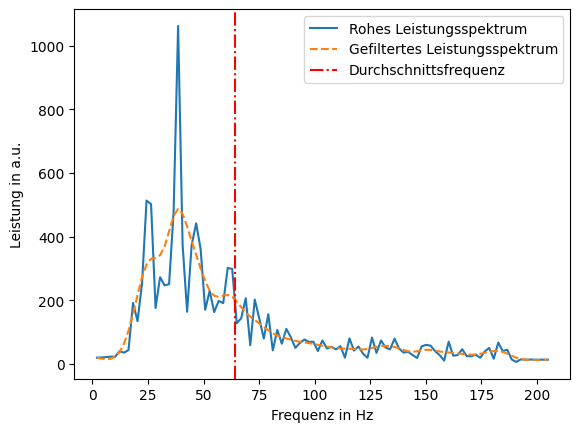

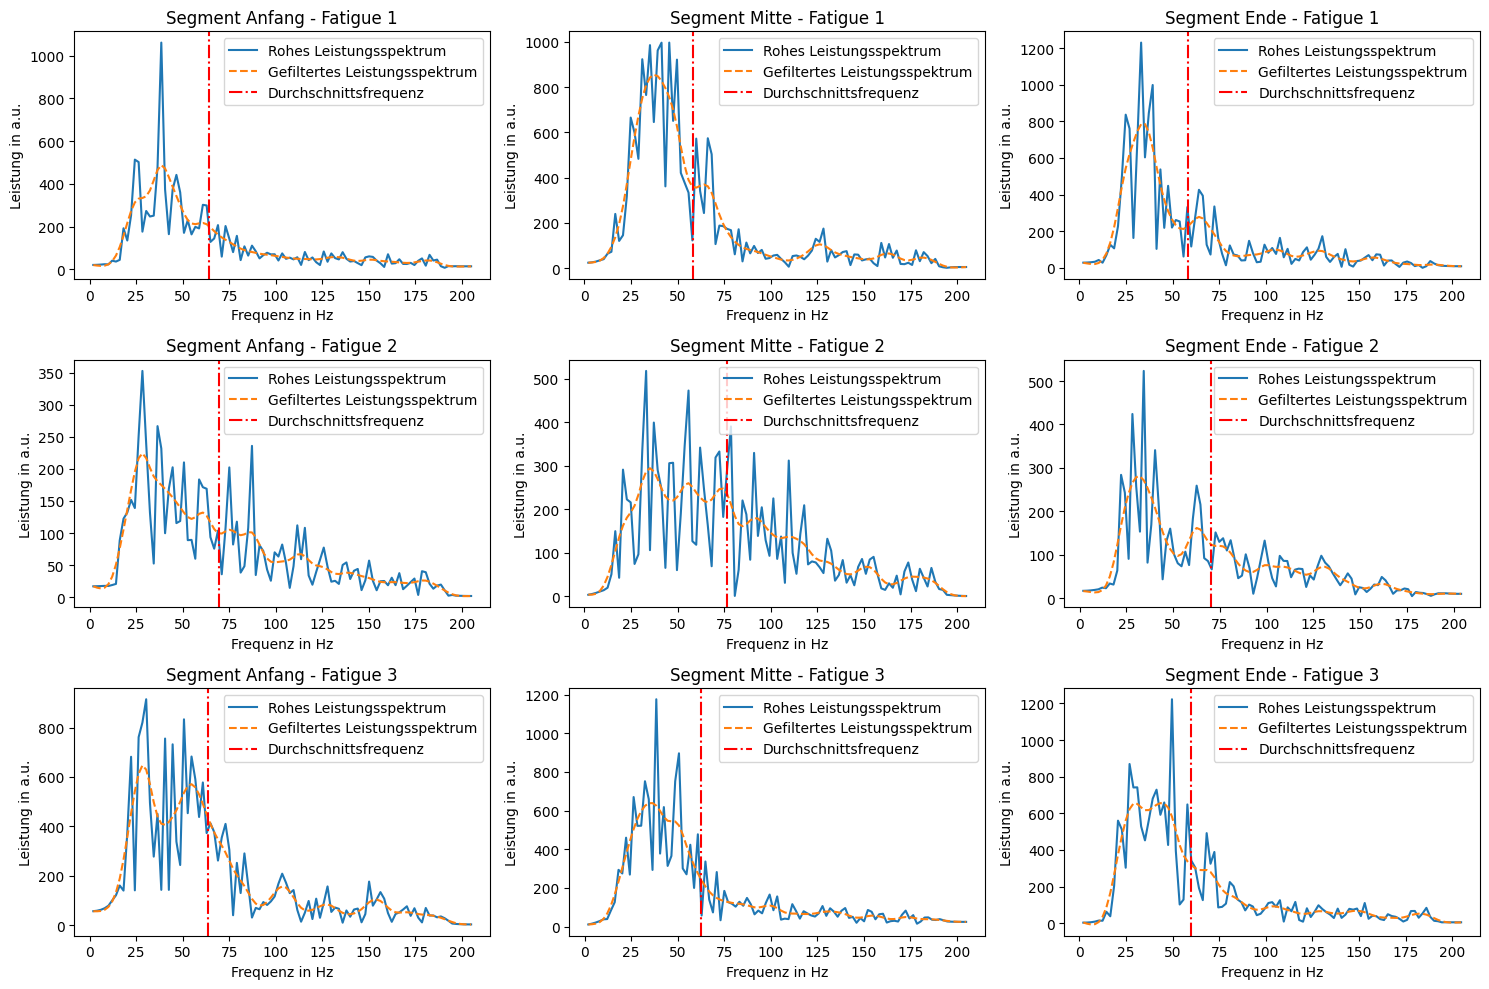

In [7]:
# Fatiguedaten einlesen
fatigue1 = pd.read_csv('Fatigue1.txt', delimiter=';')  # 1
fatigue2 = pd.read_csv('Fatigue2.txt', delimiter=';')  # 2
fatigue3 = pd.read_csv('Fatigue2.txt', delimiter=';')  # 3

# Indexlängen der Fatiguedaten finden
fatigue1_length = len(fatigue1)
fatigue2_length = len(fatigue2)
fatigue3_length = len(fatigue3)

# Fatiguedaten verarbeiten
fatigue1_processed = process_emg(fatigue.iloc[:fatigue1_length], sampling_frequency)
fatigue2_processed = process_emg(fatigue.iloc[fatigue1_length:fatigue1_length + fatigue2_length], sampling_frequency)
fatigue3_processed = process_emg(fatigue.iloc[fatigue1_length + fatigue2_length:], sampling_frequency)


# Zeit von Millisekunden auf Sekunden umwandeln
fatigue1_processed['t'] = (fatigue1_processed['t'] - fatigue1_processed['t'].iloc[0]) / 1000
fatigue2_processed['t'] = (fatigue2_processed['t'] - fatigue2_processed['t'].iloc[0]) / 1000
fatigue3_processed['t'] = (fatigue3_processed['t'] - fatigue3_processed['t'].iloc[0]) / 1000

# Daten auf die Haltephase beschränken
fatigue1_processed = fatigue1_processed[(fatigue1_processed['t'] >= 3) & (fatigue1_processed['t'] <= 17)]
fatigue2_processed = fatigue2_processed[(fatigue2_processed['t'] >= 4) & (fatigue2_processed['t'] <= 18)]
fatigue3_processed = fatigue3_processed[(fatigue3_processed['t'] >= 1) & (fatigue3_processed['t'] <= 15)]

# Zeit von fatigue1-3 jeweils von 0 starten lassen
fatigue1_processed['t'] = fatigue1_processed['t'] - fatigue1_processed['t'].iloc[0]
fatigue2_processed['t'] = fatigue2_processed['t'] - fatigue2_processed['t'].iloc[0]
fatigue3_processed['t'] = fatigue3_processed['t'] - fatigue3_processed['t'].iloc[0]

# Define beginning, middle, and end segments with fixed 0.5 second intervals
def get_fixed_segment(data, start_time, duration=0.5):
    end_time = start_time + duration
    return data[(data['t'] >= start_time) & (data['t'] < end_time)]

# Anfang, Mitte, Ende von Bursts
fatigue1_processed_beginning = get_fixed_segment(fatigue1_processed, 1) # 0-0.5s
fatigue2_processed_beginning = get_fixed_segment(fatigue2_processed, 1)
fatigue3_processed_beginning = get_fixed_segment(fatigue3_processed, 1)

fatigue1_processed_middle = get_fixed_segment(fatigue1_processed, 7)   # 7-7.5s
fatigue2_processed_middle = get_fixed_segment(fatigue2_processed, 7)
fatigue3_processed_middle = get_fixed_segment(fatigue3_processed, 7)

fatigue1_processed_end = get_fixed_segment(fatigue1_processed, 13)    # 13-13.5s
fatigue2_processed_end = get_fixed_segment(fatigue2_processed, 13)
fatigue3_processed_end = get_fixed_segment(fatigue3_processed, 13)

print(fatigue1_processed_beginning['emg_filtered'])
power1_beginning,frequencies1_beginning= lf3.get_power(fatigue1_processed_beginning['emg_filtered'], 411.76)
power2_beginning,frequencies2_beginning= lf3.get_power(fatigue2_processed_beginning['emg_filtered'], 411.76)
power3_beginning,frequencies3_beginning= lf3.get_power(fatigue3_processed_beginning['emg_filtered'], 411.76)

power1_middle,frequencies1_middle= lf3.get_power(fatigue1_processed_middle['emg_filtered'], 411.76)
power2_middle,frequencies2_middle= lf3.get_power(fatigue2_processed_middle['emg_filtered'], 411.76)
power3_middle,frequencies3_middle= lf3.get_power(fatigue3_processed_middle['emg_filtered'], 411.76)

power1_end,frequencies1_end= lf3.get_power(fatigue1_processed_end['emg_filtered'], 411.76)
power2_end,frequencies2_end= lf3.get_power(fatigue2_processed_end['emg_filtered'], 411.76)
power3_end,frequencies3_end= lf3.get_power(fatigue3_processed_end['emg_filtered'], 411.76)

#### Aufgabe 9 Plot ####
# Plot frequency1 for Beginning segment only
plt.figure()

# Raw power spectrum for Beginning segment
plt.plot(frequencies1_beginning, power1_beginning, label='Rohes Leistungsspektrum', linestyle='-')

# Filtered power spectrum using Butterworth filter with cutoff frequency of 40Hz
def butter_lowpass_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

filtered_power1_beginning = butter_lowpass_filter(power1_beginning, 40, sampling_frequency)

plt.plot(frequencies1_beginning, filtered_power1_beginning, label='Gefiltertes Leistungsspektrum', linestyle='--')

# Average frequency of filtered power spectrum for Beginning segment
average_freq = np.sum(frequencies1_beginning * filtered_power1_beginning) / np.sum(filtered_power1_beginning)

plt.axvline(average_freq, color='r', linestyle='-.', label='Durchschnittsfrequenz')

plt.xlabel('Frequenz in Hz')
plt.ylabel('Leistung in a.u.')
plt.legend()
plt.show()

###Aufgabe 9 Plot####

# Subplot für Anfang, Mitte, Ende für die drei Segmente
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

segments = ['Anfang', 'Mitte', 'Ende']
fatigue_data = [
    (fatigue1_processed_beginning, fatigue1_processed_middle, fatigue1_processed_end),
    (fatigue2_processed_beginning, fatigue2_processed_middle, fatigue2_processed_end),
    (fatigue3_processed_beginning, fatigue3_processed_middle, fatigue3_processed_end)
]

for i, (beginning, middle, end) in enumerate(fatigue_data):
    for j, segment in enumerate([beginning, middle, end]):
        power, frequencies = lf3.get_power(segment['emg_filtered'], sampling_frequency)
        filtered_power = butter_lowpass_filter(power, 40, sampling_frequency)
        
        # Calculate average frequency
        average_freq = np.sum(frequencies * filtered_power) / np.sum(filtered_power)

        axs[i, j].plot(frequencies, power, label='Rohes Leistungsspektrum', linestyle='-')
        axs[i, j].plot(frequencies, filtered_power, label='Gefiltertes Leistungsspektrum', linestyle='--')
        axs[i, j].axvline(average_freq, color='r', linestyle='-.', label='Durchschnittsfrequenz')
        axs[i, j].set_title(f'Segment {segments[j]} - Fatigue {i+1}')
        axs[i, j].set_xlabel('Frequenz in Hz')
        axs[i, j].set_ylabel('Leistung in a.u.')
        axs[i, j].legend()

plt.tight_layout()
plt.show()


Aufgabe 10


C:\Users\erics\AppData\Local\Temp\ipykernel_20708\3958948873.py:8: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

C:\Users\erics\AppData\Local\Temp\ipykernel_20708\3958948873.py:9: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

C:\Users\erics\AppData\Local\Temp\ipykernel_20708\3958948873.py:10: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



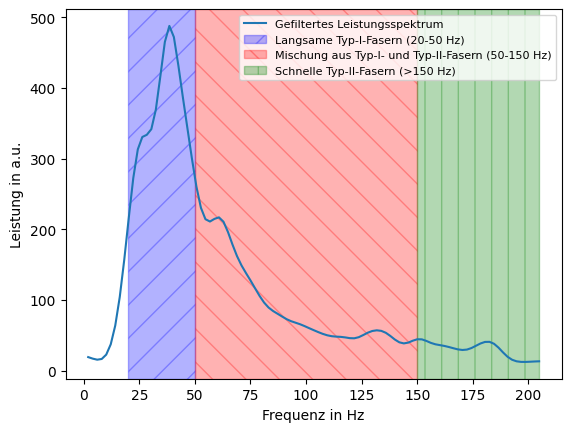

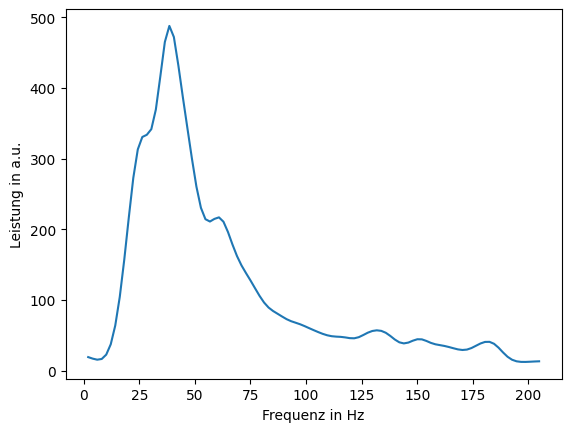

In [8]:
plt.figure()

filtered_power1_beginning = butter_lowpass_filter(power1_beginning, 40, sampling_frequency)

plt.plot(frequencies1_beginning, filtered_power1_beginning, label='Gefiltertes Leistungsspektrum', linestyle='-')

# Marking the fiber type regions with hatching patterns for better visibility in black and white prints
plt.axvspan(20, 50, color='blue', alpha=0.3, hatch='/', edgecolor='black', label='Langsame Typ-I-Fasern (20-50 Hz)')
plt.axvspan(50, 150, color='red', alpha=0.3, hatch='\\', edgecolor='black', label='Mischung aus Typ-I- und Typ-II-Fasern (50-150 Hz)')
plt.axvspan(150, max(frequencies1_beginning), color='green', alpha=0.3, hatch='|', edgecolor='black', label='Schnelle Typ-II-Fasern (>150 Hz)')

plt.xlabel('Frequenz in Hz')
plt.ylabel('Leistung in a.u.')
plt.legend(loc='upper right', prop={'size': 8})  # Adjust the font size here
plt.show()
plt.figure()

filtered_power1_beginning = butter_lowpass_filter(power1_beginning, 40, sampling_frequency)

plt.plot(frequencies1_beginning, filtered_power1_beginning, label='Gefiltertes Leistungsspektrum', linestyle='-')

plt.xlabel('Frequenz in Hz')
plt.ylabel('Leistung in a.u.') 
plt.show()

Aufgabe 11

C:\Users\erics\AppData\Local\Temp\ipykernel_20708\2611909801.py:71: DeprecationWarning:

'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0



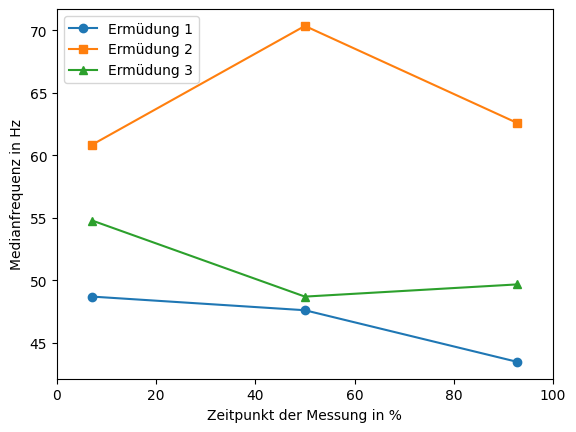

In [9]:
# Define beginning, middle, and end segments with fixed 0.5 second interval
# Analyze fatigue data and calculate median frequencies
median_freq1_beginning = calculate_median_frequency(power1_beginning, frequencies1_beginning)
median_freq1_middle = calculate_median_frequency(power1_middle, frequencies1_middle)
median_freq1_end = calculate_median_frequency(power1_end, frequencies1_end)

median_freeq2_beginning = calculate_median_frequency(power2_beginning, frequencies2_beginning)
median_freeq2_middle = calculate_median_frequency(power2_middle, frequencies2_middle)
median_freeq2_end = calculate_median_frequency(power2_end, frequencies2_end)

median_freeq3_beginning = calculate_median_frequency(power3_beginning, frequencies3_beginning)
median_freeq3_middle = calculate_median_frequency(power3_middle, frequencies3_middle)
median_freeq3_end = calculate_median_frequency(power3_end, frequencies3_end)

# Combine median frequencies for all fatigues into a list
median_freqs = [median_freq1_beginning, median_freq1_middle, median_freq1_end]
median_freqs2 = [median_freeq2_beginning, median_freeq2_middle, median_freeq2_end]
median_freqs3 = [median_freeq3_beginning, median_freeq3_middle, median_freeq3_end]

# Plot median frequencies for all fatigues with different markers
plt.figure()
plt.plot([1/14*100, 50, 13/14*100], median_freqs, label='Ermüdung 1', marker='o')
plt.plot([1/14*100, 50, 13/14*100], median_freqs2, label='Ermüdung 2', marker='s')
plt.plot([1/14*100, 50, 13/14*100], median_freqs3, label='Ermüdung 3', marker='^')
plt.xlabel('Zeitpunkt der Messung in %')
plt.ylabel('Medianfrequenz in Hz')
plt.xlim(0, 100)  # Set y-axis limit to 100
plt.legend()
plt.show()